# Exoplanet Candidate Classification with Support Vector Machine (SVM)

This notebook analyzes Kepler Objects of Interest (KOI) data to build an SVM model for predicting exoplanet candidates vs non-candidates. The analysis includes comprehensive data exploration, correlation analysis, feature scaling, hyperparameter optimization, and detailed visualizations.

## Dataset Overview
- **Training Data**: KOI-Playground-Train-Data.csv
- **Test Data**: KOI-Playground-Test-Data.csv  
- **Reference Data**: data/KOI Selected Data.csv
- **Target Variable**: koi_disposition (candidate vs non-candidate)

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_auc_score, roc_curve, 
                           precision_recall_curve, auc)
from sklearn.feature_selection import mutual_info_classif

# Support Vector Machine
from sklearn.svm import SVC

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Principal Component Analysis for visualization
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load the datasets
print("Loading datasets...")

# Load training data
train_data = pd.read_csv('KOI-Playground-Train-Data.csv')
print(f"Training data shape: {train_data.shape}")

# Note: We'll use only the training data for all phases:
# - Split it for training/validation during development
# - Use 100% for final model training after hyperparameter optimization

print("\nDataset loaded successfully!")
print("Using training data for all phases: training, validation, and final model training")

Loading datasets...
Training data shape: (7651, 20)

Dataset loaded successfully!
Using training data for all phases: training, validation, and final model training


In [3]:
# Explore the training dataset
print("=== TRAINING DATA EXPLORATION ===")
print(f"Shape: {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")
print(f"\nData types:")
print(train_data.dtypes)

print(f"\nFirst few rows:")
display(train_data.head())

print(f"\nTarget variable distribution:")
print(train_data['koi_disposition'].value_counts())
print(f"\nTarget variable percentages:")
print(train_data['koi_disposition'].value_counts(normalize=True) * 100)

=== TRAINING DATA EXPLORATION ===
Shape: (7651, 20)
Columns: ['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_datalink_dvr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

Data types:
kepid                 int64
koi_disposition      object
koi_period          float64
koi_time0bk         float64
koi_time0           float64
koi_eccen           float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_sma             float64
koi_incl            float64
koi_model_snr       float64
koi_count             int64
koi_bin_oedp_sig    float64
koi_datalink_dvr     object
koi_steff           float64
koi_slogg           float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
dtype: object

First few rows:


,kepid,koi_disposition,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_impact,koi_duration,koi_depth,koi_sma,koi_incl,koi_model_snr,koi_count,koi_bin_oedp_sig,koi_datalink_dvr,koi_steff,koi_slogg,koi_srad,koi_smass,koi_kepmag
0,7870250,non-candidate,0.580725,131.72956,2454964.730,0.0,0.292,1.8200,64.2,0.0136,83.11,16.9,1,0.9930,007/007870/007870250/dv/kplr007870250-20160209...,5989.0,4.492,0.933,0.986,14.569
1,11651712,candidate,14.532605,140.46850,2454973.468,0.0,0.112,2.4212,328.9,0.1173,89.86,29.0,1,0.2915,011/011651/011651712/dv/kplr011651712-20160209...,6003.0,4.507,0.932,1.019,13.785
2,4945877,non-candidate,1.339670,132.16786,2454965.168,0.0,0.602,1.8950,28.6,0.0289,82.16,21.7,1,0.0005,004/004945/004945877/dv/kplr004945877-20160209...,8867.0,3.988,2.245,1.789,10.455
3,6289344,non-candidate,160.412202,262.40022,2455095.400,0.0,0.903,4.9200,2538.0,0.5375,89.62,24.4,1,0.0000,006/006289/006289344/dv/kplr006289344-20160209...,5269.0,4.620,0.727,0.812,15.407
4,9843517,candidate,11.937835,133.26120,2454966.261,0.0,0.036,4.6520,246.0,0.0954,89.90,9.6,1,0.9246,009/009843/009843517/dv/kplr009843517-20160209...,5469.0,4.611,0.738,0.826,15.954



Target variable distribution:
koi_disposition
non-candidate    3900
candidate        3751
Name: count, dtype: int64

Target variable percentages:
koi_disposition
non-candidate    50.973729
candidate        49.026271
Name: proportion, dtype: float64


In [4]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")
missing_train = train_data.isnull().sum()
missing_percent_train = (missing_train / len(train_data)) * 100

# Create summary DataFrame for training data
missing_summary = pd.DataFrame({
    'Column': train_data.columns,
    'Train_Missing': missing_train.values,
    'Train_Missing_%': missing_percent_train.values
})

missing_summary = missing_summary[missing_summary['Train_Missing'] > 0].sort_values('Train_Missing_%', ascending=False)
print("Columns with missing values in training data:")
display(missing_summary)

=== MISSING VALUES ANALYSIS ===
Columns with missing values in training data:


,Column,Train_Missing,Train_Missing_%
13,koi_bin_oedp_sig,1226,16.024049
10,koi_incl,288,3.764214
5,koi_eccen,287,3.751144
8,koi_depth,287,3.751144
6,koi_impact,287,3.751144
9,koi_sma,287,3.751144
11,koi_model_snr,287,3.751144
15,koi_steff,287,3.751144
16,koi_slogg,287,3.751144
18,koi_smass,287,3.751144


## 3. Data Preprocessing and Cleaning

In [5]:
# Create working copy of the data
train_df = train_data.copy()

print("=== DATA PREPROCESSING ===")

# Remove columns that are not useful for modeling
columns_to_drop = ['kepid', 'koi_datalink_dvr']  # ID columns and URLs
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {len(train_df.columns)}")

# Handle missing values
print(f"\nHandling missing values...")

# For numerical features, fill missing values with median
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
numerical_cols = numerical_cols.drop('koi_disposition', errors='ignore')

for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} with median: {median_val}")

print(f"\nMissing values after preprocessing:")
print(f"Train: {train_df.isnull().sum().sum()}")

=== DATA PREPROCESSING ===
Dropped columns: ['kepid', 'koi_datalink_dvr']
Remaining columns: 18

Handling missing values...
Filled koi_eccen with median: 0.0
Filled koi_impact with median: 0.5356
Filled koi_depth with median: 425.95
Filled koi_sma with median: 0.0858
Filled koi_incl with median: 88.52
Filled koi_model_snr with median: 23.2
Filled koi_bin_oedp_sig with median: 0.4776
Filled koi_steff with median: 5767.0
Filled koi_slogg with median: 4.438
Filled koi_srad with median: 1.0
Filled koi_smass with median: 0.975
Filled koi_kepmag with median: 14.523

Missing values after preprocessing:
Train: 0


In [6]:
# Convert target variable to binary
print("=== TARGET VARIABLE PREPROCESSING ===")
print(f"Original target distribution:\n{train_df['koi_disposition'].value_counts()}")

# Create binary target: 1 for candidate, 0 for non-candidate
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df['koi_disposition'])

print(f"\nEncoded target distribution:")
print(f"Training: {pd.Series(train_df['target']).value_counts()}")

# Map target values
target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\nTarget mapping: {target_mapping}")

# Remove original disposition column
train_df = train_df.drop('koi_disposition', axis=1)

=== TARGET VARIABLE PREPROCESSING ===
Original target distribution:
koi_disposition
non-candidate    3900
candidate        3751
Name: count, dtype: int64

Encoded target distribution:
Training: target
1    3900
0    3751
Name: count, dtype: int64

Target mapping: {'candidate': np.int64(0), 'non-candidate': np.int64(1)}


## 4. Exploratory Data Analysis and Visualizations

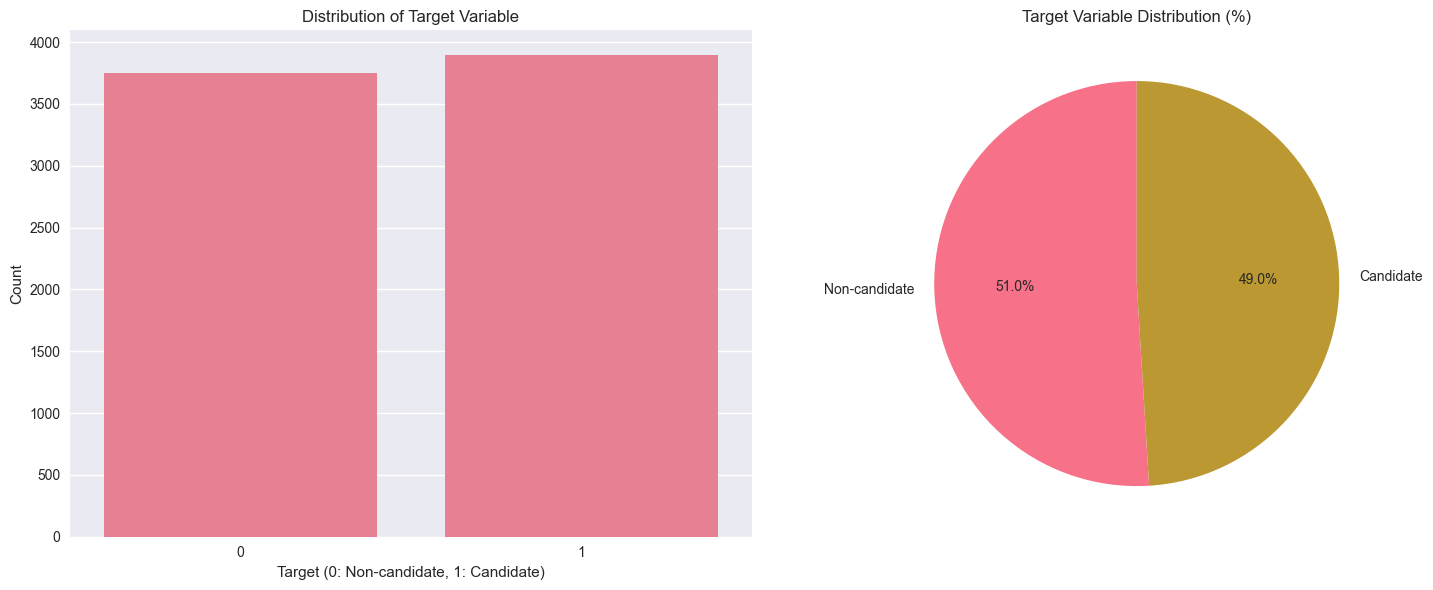

Class distribution:
Non-candidates: 3751 (49.0%)
Candidates: 3900 (51.0%)


In [7]:
# Target variable distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sns.countplot(data=train_df, x='target', ax=ax1)
ax1.set_title('Distribution of Target Variable')
ax1.set_xlabel('Target (0: Non-candidate, 1: Candidate)')
ax1.set_ylabel('Count')

# Pie chart
target_counts = train_df['target'].value_counts()
labels = ['Non-candidate', 'Candidate']
ax2.pie(target_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Target Variable Distribution (%)')

plt.tight_layout()
plt.show()

print(f"Class distribution:")
print(f"Non-candidates: {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Candidates: {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")

=== STATISTICAL SUMMARY ===


,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_impact,koi_duration,koi_depth,koi_sma,koi_incl,koi_model_snr,koi_count,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_srad,koi_smass,koi_kepmag
count,7651.000000,7651.000000,7.651000e+03,7651.0,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
mean,78.949367,166.233155,2.454999e+06,0.0,0.742397,5.588467,23576.263698,0.219708,82.725218,257.851627,1.401778,0.413766,5707.377859,4.314932,1.713210,1.022368,14.271088
std,1490.783724,67.967030,6.796703e+01,0.0,3.545547,6.421504,81683.955294,0.600184,14.956793,800.560194,0.863261,0.463809,775.723699,0.426656,6.109861,0.345026,1.383109
min,0.241843,120.565925,2.454954e+06,0.0,0.000000,0.104600,0.800000,0.006500,2.290000,0.000000,1.000000,-1.000000,2661.000000,0.047000,0.109000,0.094000,6.966000
25%,2.755346,132.758795,2.454966e+06,0.0,0.209050,2.430250,168.050000,0.039700,84.300000,12.200000,1.000000,0.188300,5332.500000,4.229000,0.834000,0.853000,13.452500
50%,9.931463,137.260750,2.454970e+06,0.0,0.535600,3.778000,425.950000,0.085800,88.520000,23.200000,1.000000,0.477600,5767.000000,4.438000,1.000000,0.975000,14.523000
75%,40.857236,170.824209,2.455004e+06,0.0,0.878000,6.254500,1389.650000,0.203800,89.750000,73.400000,1.000000,0.745200,6100.000000,4.540000,1.320000,1.097000,15.322000
max,129995.778400,1472.522306,2.456306e+06,0.0,100.806000,138.540000,921670.000000,44.989200,90.000000,9054.700000,7.000000,1.000000,11360.000000,5.364000,229.908000,3.735000,20.003000


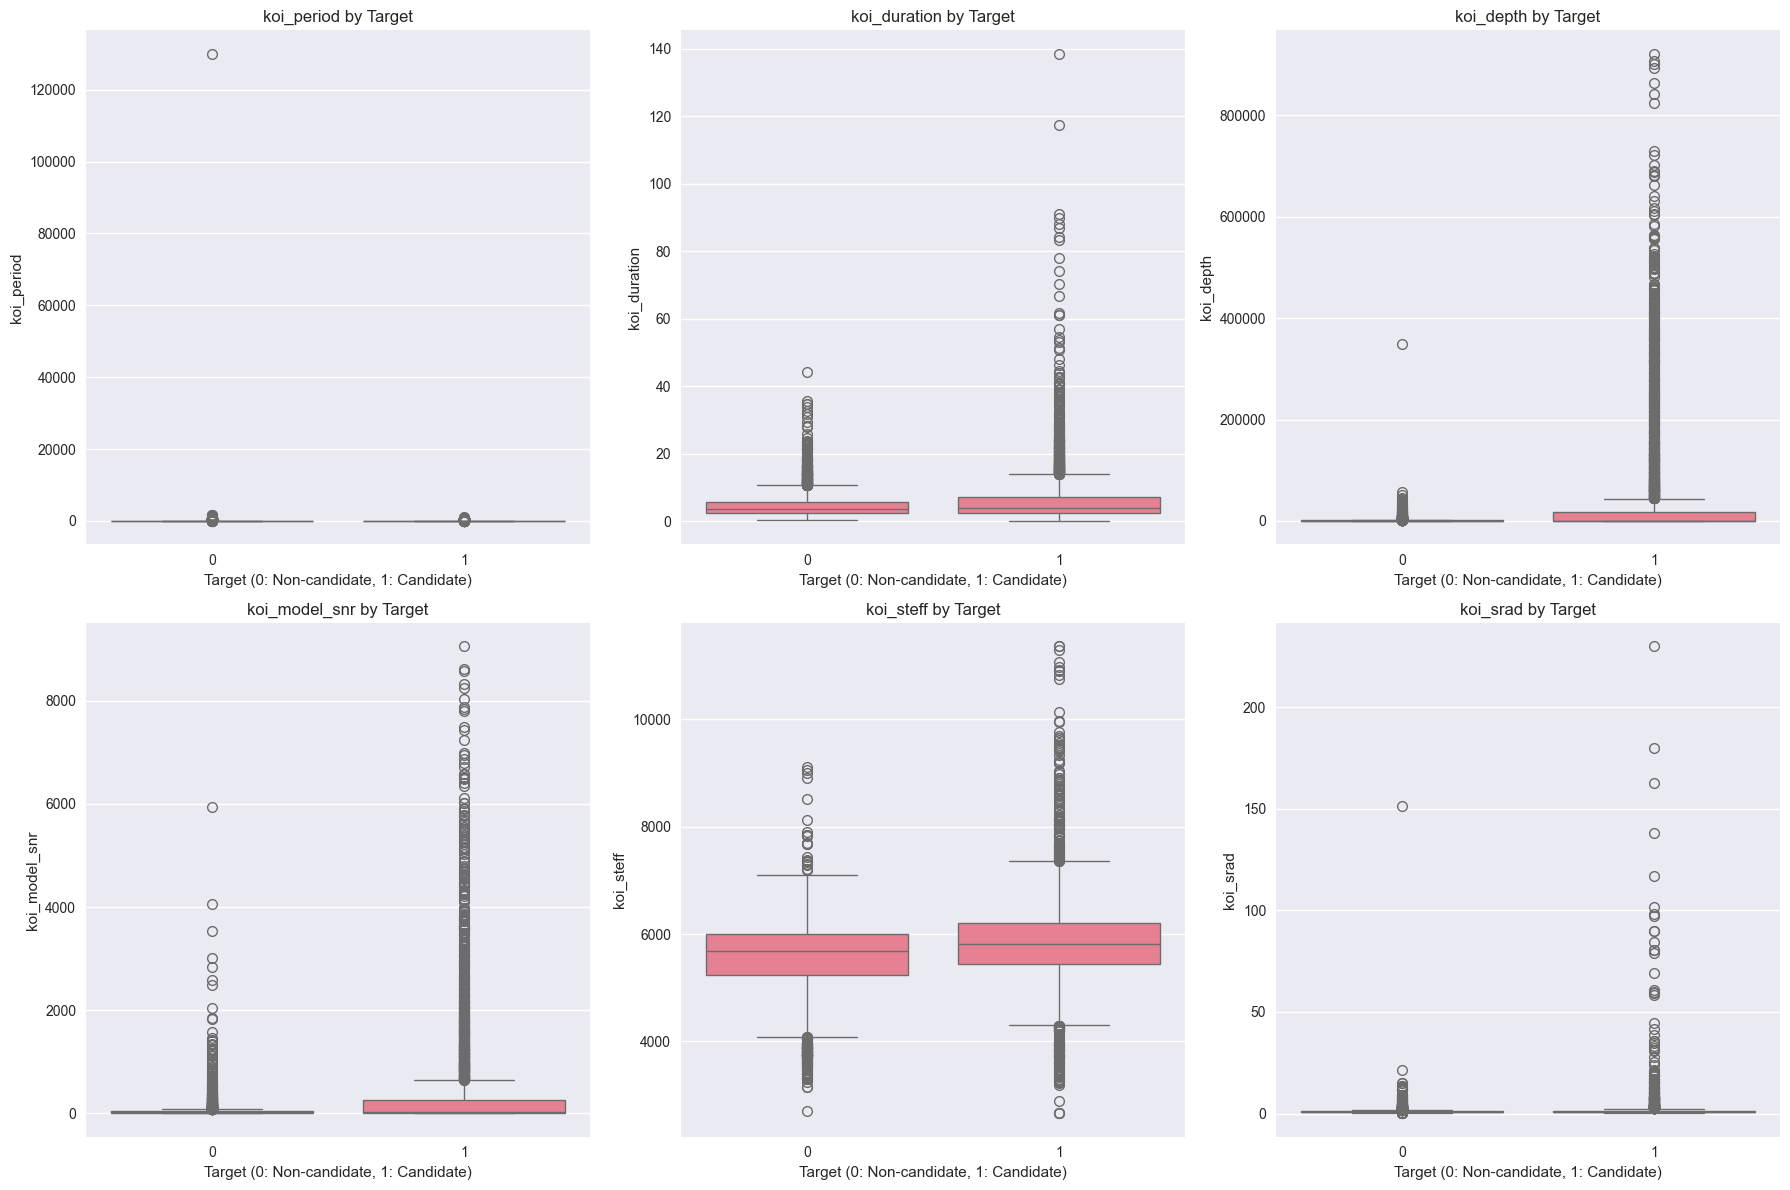

In [8]:
# Statistical summary of numerical features
numerical_features = train_df.select_dtypes(include=[np.number]).columns.drop('target')

print("=== STATISTICAL SUMMARY ===")
display(train_df[numerical_features].describe())

# Box plots for key features
key_features = ['koi_period', 'koi_duration', 'koi_depth', 'koi_model_snr', 'koi_steff', 'koi_srad']
key_features = [f for f in key_features if f in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    sns.boxplot(data=train_df, x='target', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Target')
    axes[i].set_xlabel('Target (0: Non-candidate, 1: Candidate)')

plt.tight_layout()
plt.show()

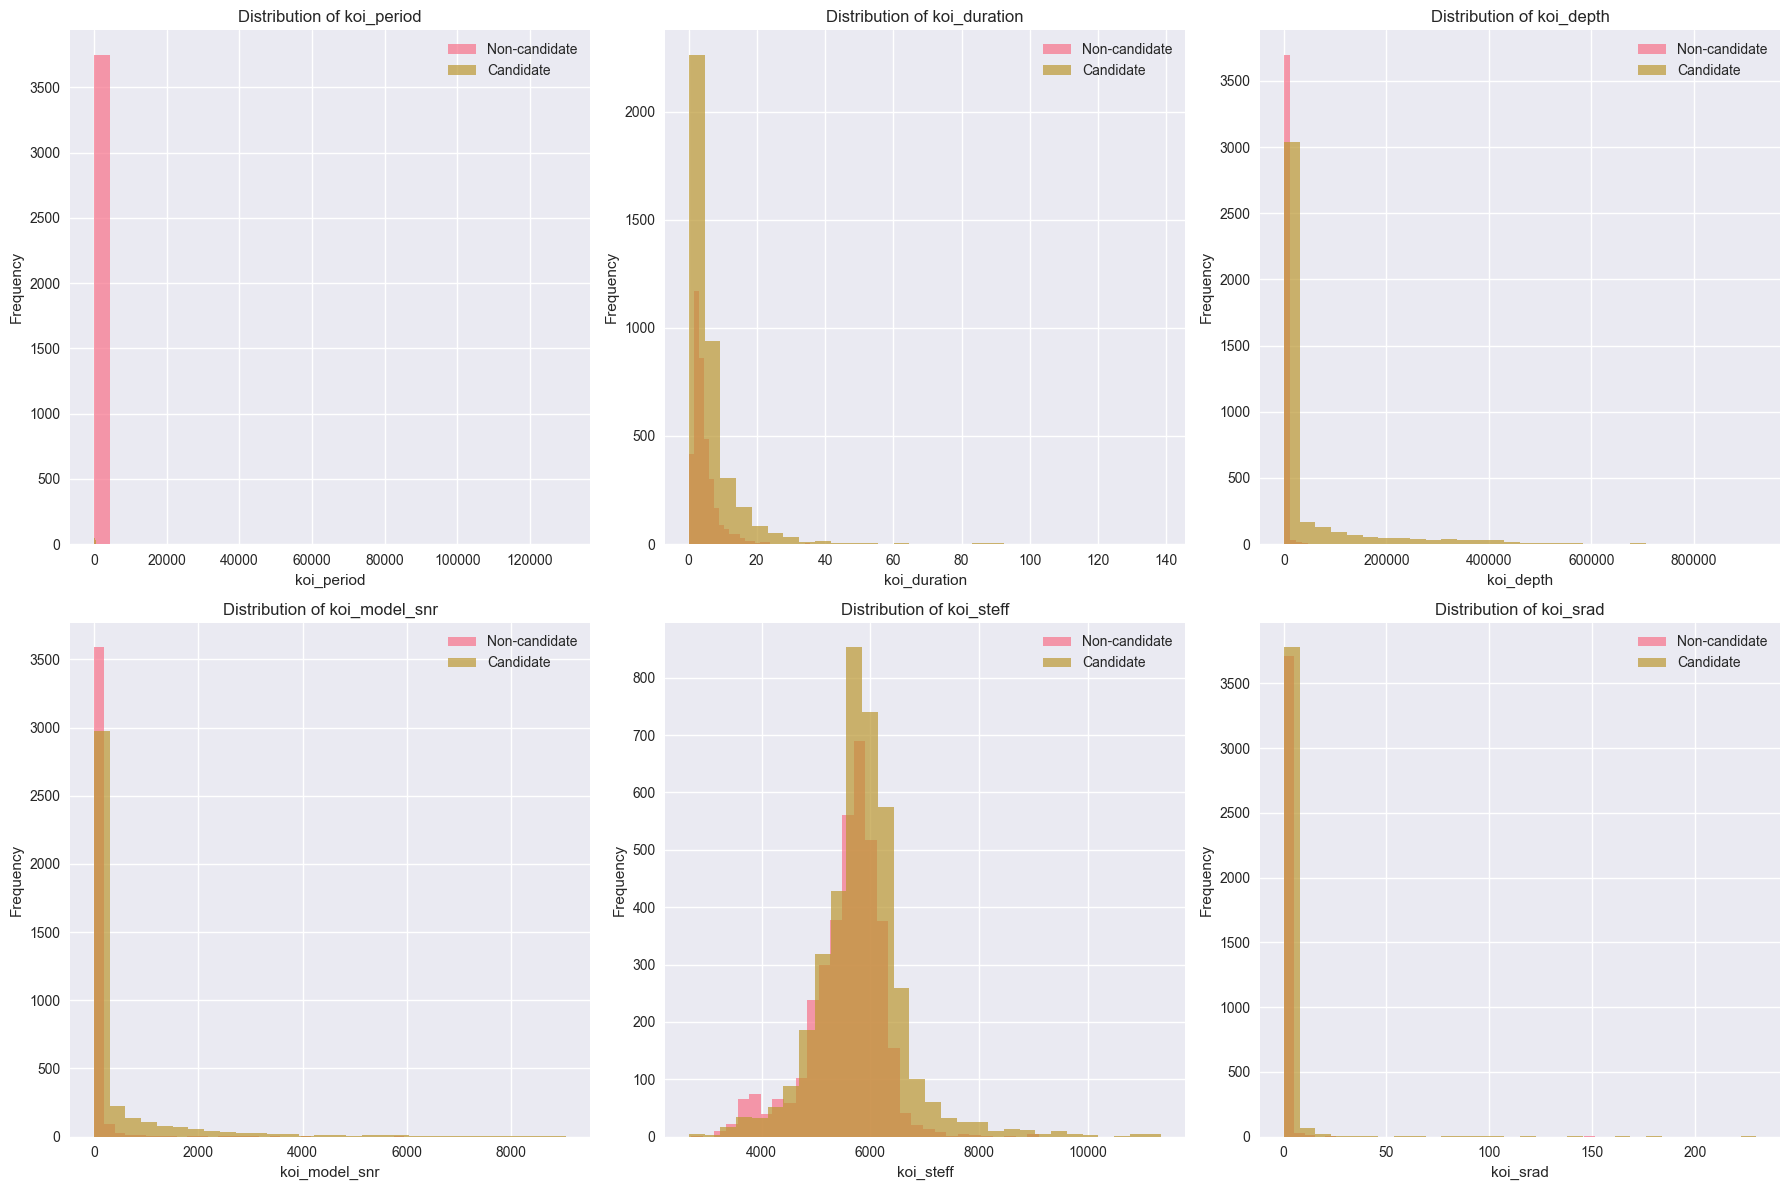

In [9]:
# Distribution plots for key features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    for target_val in [0, 1]:
        data_subset = train_df[train_df['target'] == target_val][feature]
        label = 'Candidate' if target_val == 1 else 'Non-candidate'
        axes[i].hist(data_subset, alpha=0.7, label=label, bins=30)
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

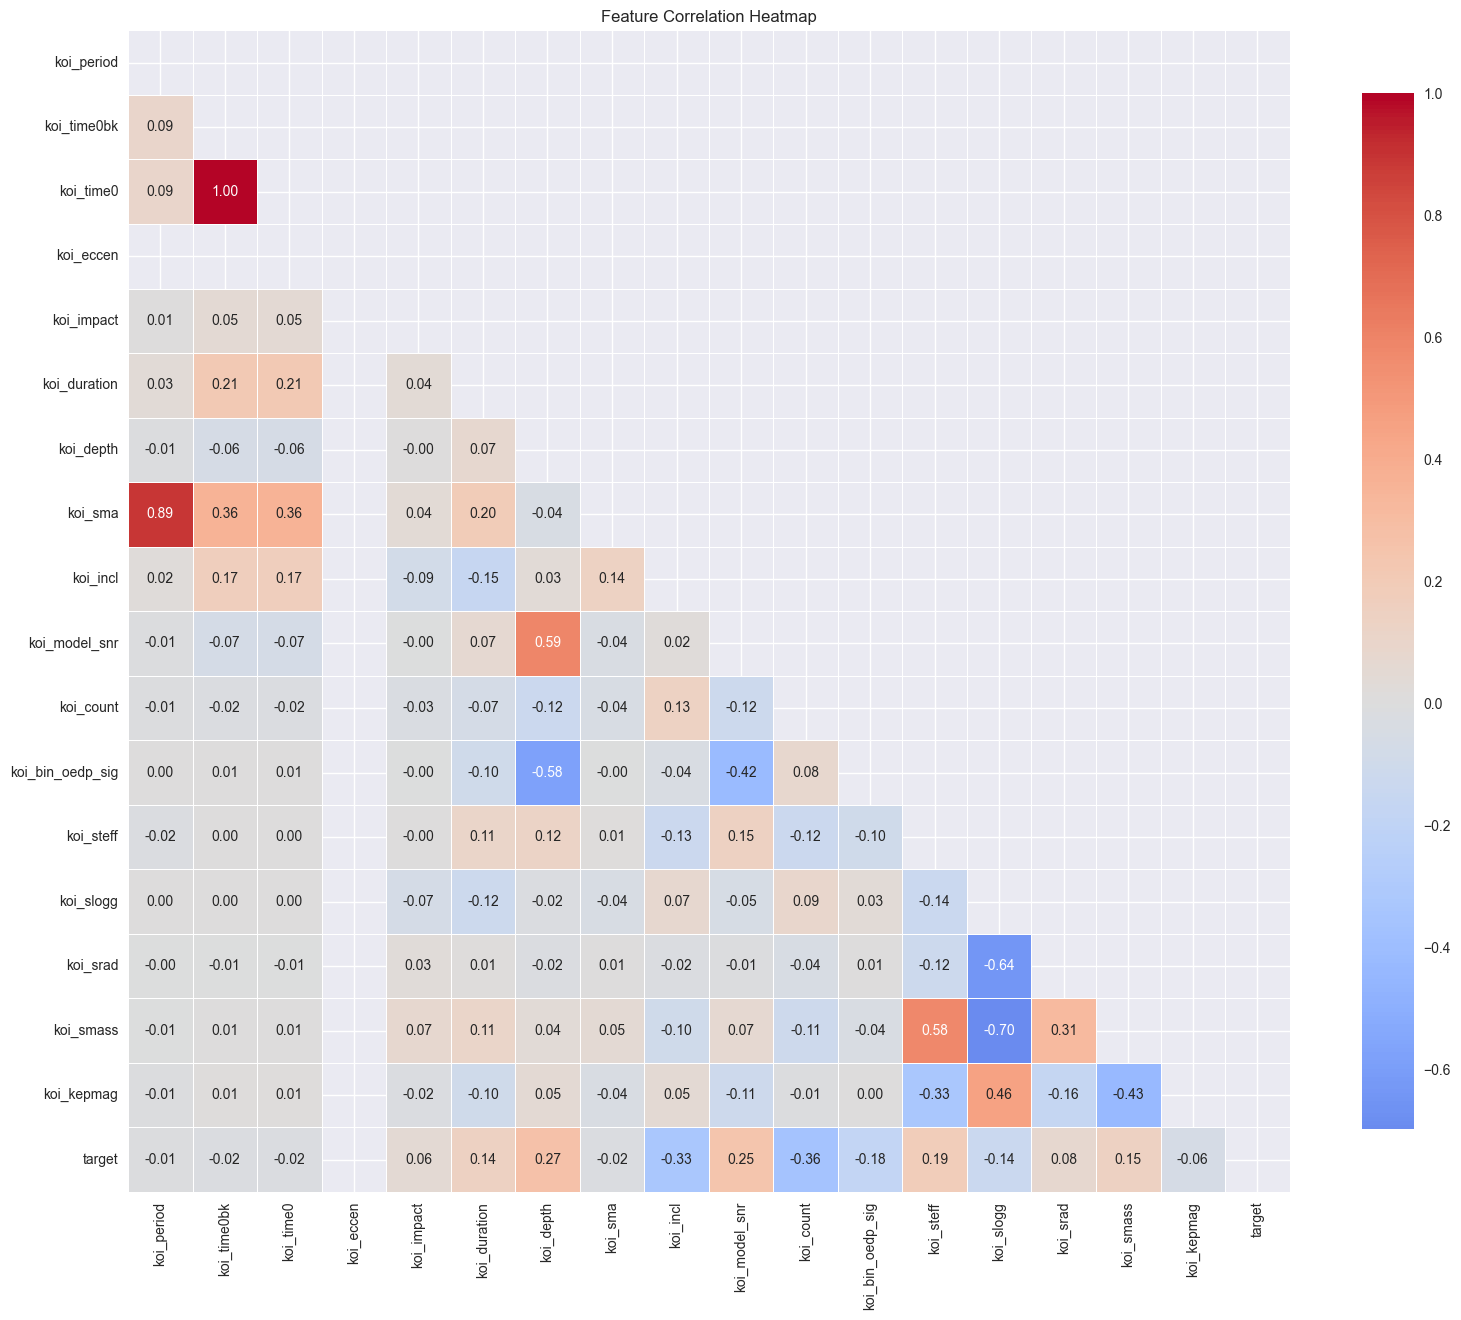

=== CORRELATIONS WITH TARGET VARIABLE ===
koi_count          -0.363746
koi_incl           -0.328246
koi_depth           0.269196
koi_model_snr       0.247527
koi_steff           0.185802
koi_bin_oedp_sig   -0.184533
koi_smass           0.147843
koi_duration        0.143548
koi_slogg          -0.140258
koi_srad            0.077139
koi_kepmag         -0.056727
koi_impact          0.055451
koi_time0bk        -0.015650
koi_time0          -0.015649
koi_sma            -0.015446
koi_period         -0.009252
koi_eccen                NaN
Name: target, dtype: float64


In [10]:
# Get numerical features after target creation
numerical_features = train_df.select_dtypes(include=[np.number]).columns.drop('target')

# Calculate correlation matrix
correlation_matrix = train_df[numerical_features.tolist() + ['target']].corr()

# Create correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_correlations = correlation_matrix['target'].sort_values(key=abs, ascending=False)
print("=== CORRELATIONS WITH TARGET VARIABLE ===")
print(target_correlations.drop('target'))

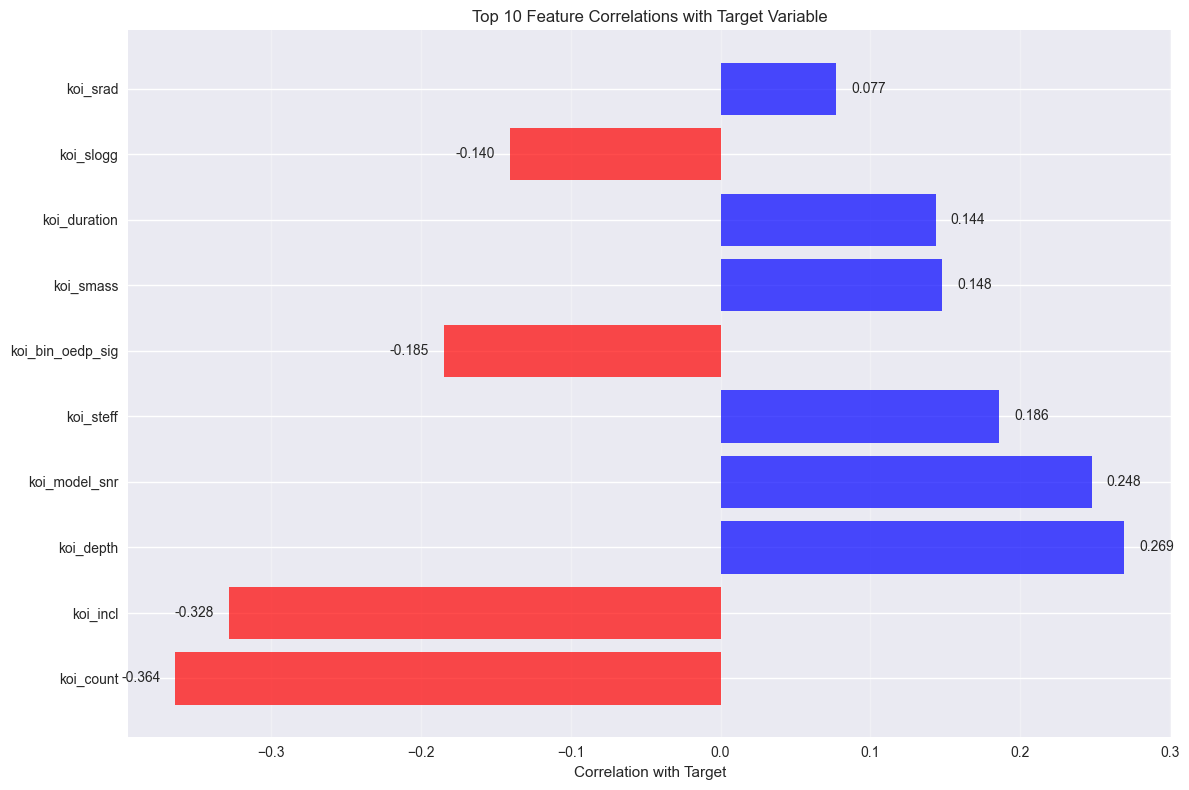

In [11]:
# Visualize top correlations with target
top_correlations = target_correlations.drop('target').head(10)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlation with Target')
plt.title('Top 10 Feature Correlations with Target Variable')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_correlations.values)):
    plt.text(value + (0.01 if value > 0 else -0.01), i, f'{value:.3f}', 
             ha='left' if value > 0 else 'right', va='center')

plt.tight_layout()
plt.show()

## 6. Feature Engineering and Selection

In [12]:
# Prepare features for modeling
print("=== FEATURE ENGINEERING ===")

# Separate features and target from the training data
feature_columns = [col for col in train_df.columns if col != 'target']
X_full = train_df[feature_columns].copy()
y_full = train_df['target'].copy()

print(f"Number of original features: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

# Create additional engineered features
print(f"\nCreating engineered features...")

# Ratio features
if 'koi_depth' in X_full.columns and 'koi_duration' in X_full.columns:
    X_full['depth_duration_ratio'] = X_full['koi_depth'] / (X_full['koi_duration'] + 1e-6)
    feature_columns.append('depth_duration_ratio')

if 'koi_period' in X_full.columns and 'koi_sma' in X_full.columns:
    X_full['period_sma_ratio'] = X_full['koi_period'] / (X_full['koi_sma'] + 1e-6)
    feature_columns.append('period_sma_ratio')

# Log transformations for highly skewed features
skewed_features = ['koi_period', 'koi_depth', 'koi_sma']
skewed_features = [f for f in skewed_features if f in X_full.columns]

for feature in skewed_features:
    X_full[f'{feature}_log'] = np.log1p(X_full[feature])
    feature_columns.append(f'{feature}_log')

print(f"Total features after engineering: {len(feature_columns)}")

# Update X_full with new features
X_full = X_full[feature_columns]

# Handle any remaining missing values after feature engineering
print(f"\nChecking for missing values after feature engineering...")
print(f"X_full missing values: {X_full.isnull().sum().sum()}")

if X_full.isnull().sum().sum() > 0:
    print("Filling remaining missing values...")
    # Fill any remaining missing values with median for numerical features
    for col in X_full.columns:
        if X_full[col].isnull().sum() > 0:
            median_val = X_full[col].median()
            if pd.isna(median_val):  # If median is still NaN, use 0
                median_val = 0
            X_full[col].fillna(median_val, inplace=True)
            print(f"  Filled {col} with {median_val}")

print(f"Final missing values check:")
print(f"  X_full: {X_full.isnull().sum().sum()}")
print(f"  Total samples available: {len(X_full)}")

=== FEATURE ENGINEERING ===
Number of original features: 17
Feature columns: ['koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

Creating engineered features...
Total features after engineering: 22

Checking for missing values after feature engineering...
X_full missing values: 0
Final missing values check:
  X_full: 0
  Total samples available: 7651


## 7. Feature Importance Analysis

=== MUTUAL INFORMATION ANALYSIS ===
Top 15 features by Mutual Information:
koi_period              0.115891
koi_period_log          0.115733
koi_depth_log           0.112939
koi_depth               0.109714
koi_incl                0.106341
depth_duration_ratio    0.097317
koi_count               0.090597
koi_impact              0.086788
period_sma_ratio        0.084375
koi_bin_oedp_sig        0.080359
koi_model_snr           0.076751
koi_sma_log             0.074419
koi_sma                 0.068465
koi_steff               0.064131
koi_srad                0.055911
dtype: float64


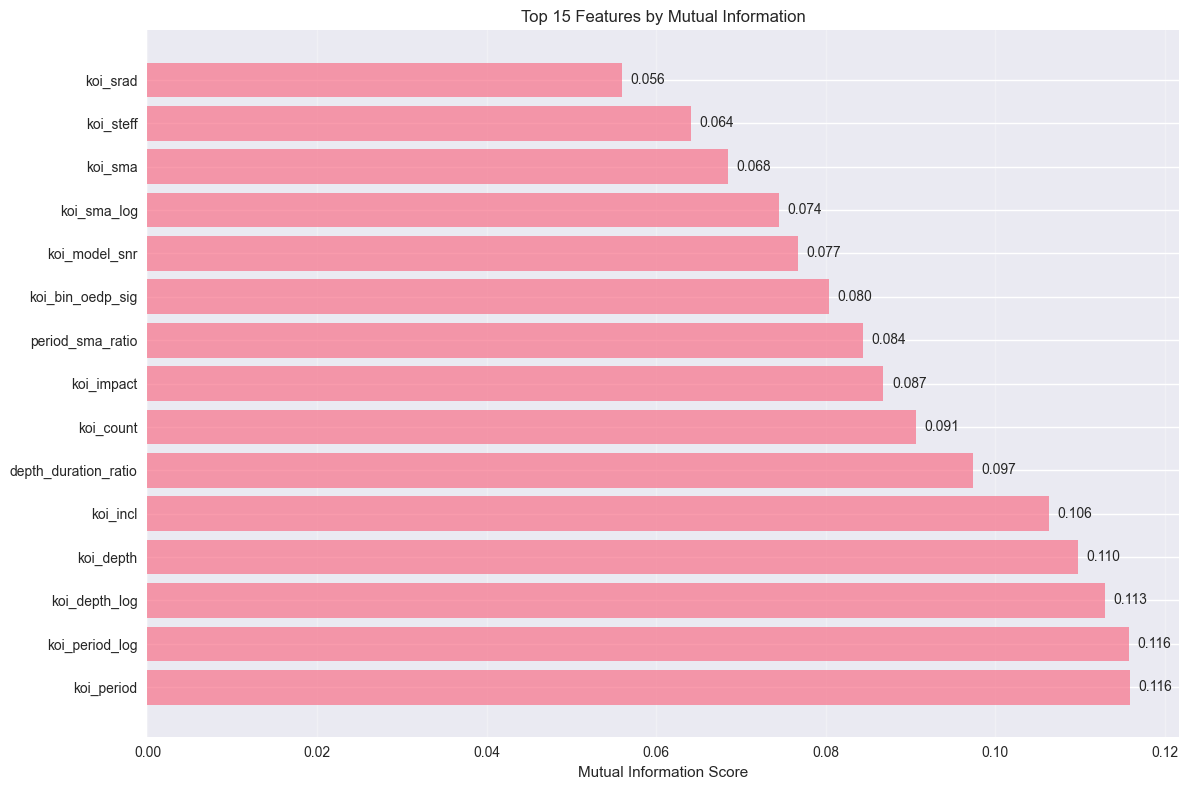

In [13]:
# Mutual Information for feature importance
print("=== MUTUAL INFORMATION ANALYSIS ===")

# Calculate mutual information using full dataset
mi_scores = mutual_info_classif(X_full, y_full, random_state=42)
mi_scores = pd.Series(mi_scores, index=X_full.columns).sort_values(ascending=False)

print("Top 15 features by Mutual Information:")
print(mi_scores.head(15))

# Visualize mutual information scores
plt.figure(figsize=(12, 8))
top_mi = mi_scores.head(15)
bars = plt.barh(range(len(top_mi)), top_mi.values, alpha=0.7)
plt.yticks(range(len(top_mi)), top_mi.index)
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_mi.values)):
    plt.text(value + 0.001, i, f'{value:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## 8. Data Splitting and Feature Scaling

In [14]:
# Split training data for validation during development phase
print("=== DATA SPLITTING FOR DEVELOPMENT ===")

# Split the full training data into train/validation for hyperparameter tuning
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Development training set shape: {X_train_split.shape}")
print(f"Development validation set shape: {X_val.shape}")
print(f"Full training set shape: {X_full.shape}")

print(f"\nClass distribution:")
print(f"Development training: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Development validation: {pd.Series(y_val).value_counts().sort_index()}")
print(f"Full training set: {pd.Series(y_full).value_counts().sort_index()}")

# Feature scaling - Critical for SVM
print("\n=== FEATURE SCALING ===")
print("SVM is sensitive to feature scales. Applying StandardScaler...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

print(f"Features scaled using StandardScaler")
print(f"Training set - mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")

# Display feature summary
print(f"\nFinal feature set ({len(X_full.columns)} features):")
for i, col in enumerate(X_full.columns, 1):
    print(f"{i:2d}. {col}")

=== DATA SPLITTING FOR DEVELOPMENT ===
Development training set shape: (6120, 22)
Development validation set shape: (1531, 22)
Full training set shape: (7651, 22)

Class distribution:
Development training: target
0    3000
1    3120
Name: count, dtype: int64
Development validation: target
0    751
1    780
Name: count, dtype: int64
Full training set: target
0    3751
1    3900
Name: count, dtype: int64

=== FEATURE SCALING ===
SVM is sensitive to feature scales. Applying StandardScaler...
Features scaled using StandardScaler
Training set - mean: -0.000000, std: 0.977008

Final feature set (22 features):
 1. koi_period
 2. koi_time0bk
 3. koi_time0
 4. koi_eccen
 5. koi_impact
 6. koi_duration
 7. koi_depth
 8. koi_sma
 9. koi_incl
10. koi_model_snr
11. koi_count
12. koi_bin_oedp_sig
13. koi_steff
14. koi_slogg
15. koi_srad
16. koi_smass
17. koi_kepmag
18. depth_duration_ratio
19. period_sma_ratio
20. koi_period_log
21. koi_depth_log
22. koi_sma_log


## 9. Support Vector Machine Model Implementation

In [15]:
# Initialize SVM model with initial parameters
print("=== SVM MODEL INITIALIZATION ===")

# Initial model parameters
initial_params = {
    'kernel': 'rbf',  # Radial Basis Function kernel
    'C': 1.0,         # Regularization parameter
    'gamma': 'scale', # Kernel coefficient
    'random_state': 42,
    'probability': True  # Enable probability estimates
}

# Create initial model
svm_model = SVC(**initial_params)

print("Initial SVM parameters:")
for param, value in initial_params.items():
    print(f"  {param}: {value}")

print(f"\nSVM Configuration:")
print(f"  • Kernel: RBF (Radial Basis Function)")
print(f"  • Regularization (C): Controls trade-off between smooth decision boundary and classification accuracy")
print(f"  • Gamma: Controls influence of single training examples")
print(f"  • Probability: Enabled for probability predictions")

=== SVM MODEL INITIALIZATION ===
Initial SVM parameters:
  kernel: rbf
  C: 1.0
  gamma: scale
  random_state: 42
  probability: True

SVM Configuration:
  • Kernel: RBF (Radial Basis Function)
  • Regularization (C): Controls trade-off between smooth decision boundary and classification accuracy
  • Gamma: Controls influence of single training examples
  • Probability: Enabled for probability predictions


## 10. Model Training and Initial Evaluation

In [16]:
# Train initial model
print("=== TRAINING INITIAL SVM MODEL ===")

# Train the model
svm_model.fit(X_train_scaled, y_train_split)

# Make predictions
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_train_pred_proba = svm_model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_proba = svm_model.predict_proba(X_val_scaled)[:, 1]

print("Model training completed!")

# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, dataset_name):
    """Evaluate model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n{dataset_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_roc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

# Evaluate initial model
train_metrics = evaluate_model(y_train_split, y_train_pred, y_train_pred_proba, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_pred_proba, "Validation")

=== TRAINING INITIAL SVM MODEL ===
Model training completed!

Training Performance:
  Accuracy:  0.8387
  Precision: 0.8559
  Recall:    0.8221
  F1-Score:  0.8386
  AUC-ROC:   0.9102

Validation Performance:
  Accuracy:  0.8067
  Precision: 0.8227
  Recall:    0.7910
  F1-Score:  0.8065
  AUC-ROC:   0.8795


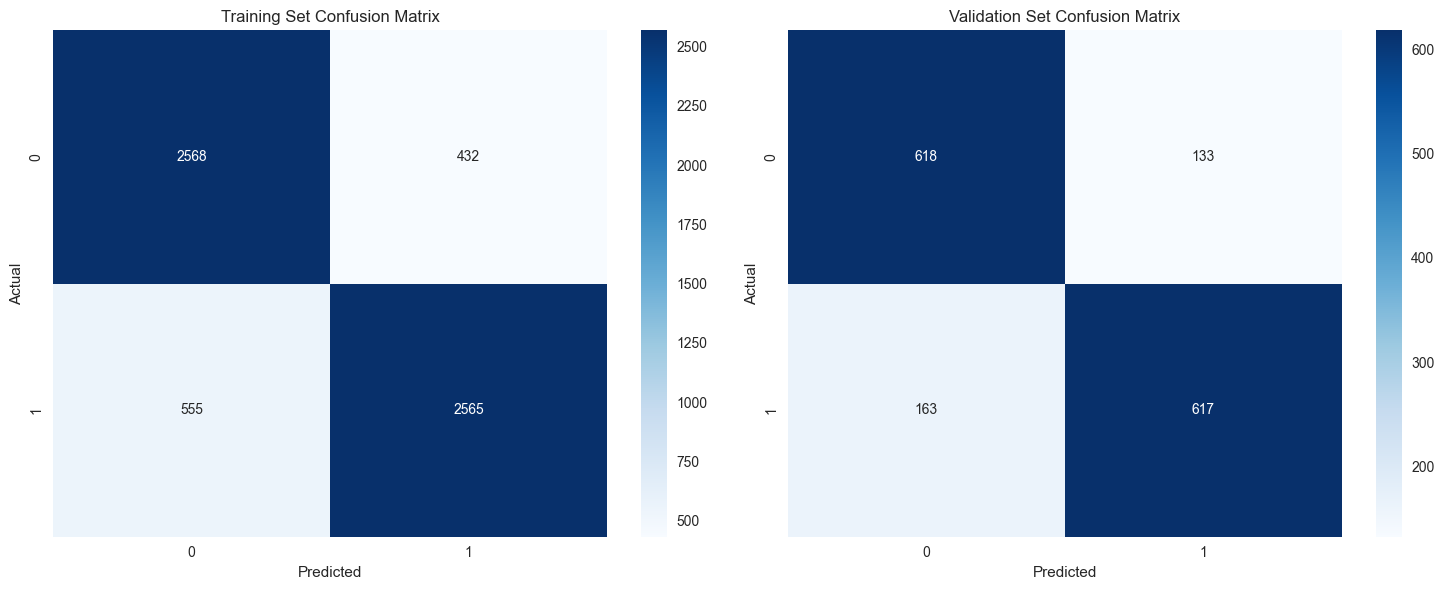


=== DETAILED CLASSIFICATION REPORT ===
Validation Set:
               precision    recall  f1-score   support

Non-candidate       0.79      0.82      0.81       751
    Candidate       0.82      0.79      0.81       780

     accuracy                           0.81      1531
    macro avg       0.81      0.81      0.81      1531
 weighted avg       0.81      0.81      0.81      1531



In [17]:
# Confusion matrix and classification report
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
cm_train = confusion_matrix(y_train_split, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Validation confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Validation Set Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print("Validation Set:")
print(classification_report(y_val, y_val_pred, target_names=['Non-candidate', 'Candidate']))

## 11. Hyperparameter Optimization

In [19]:
# Define hyperparameter grid for optimization
print("=== HYPERPARAMETER OPTIMIZATION ===")

# Parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4]  # Only for polynomial kernel
}

print("Parameter grid for optimization:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Create base model for hyperparameter tuning
base_svm = SVC(random_state=42, probability=True)

# Use GridSearchCV for comprehensive search (SVM is generally faster than tree-based models)
print(f"\nStarting GridSearchCV...")
print(f"This may take several minutes...")

grid_search = GridSearchCV(
    estimator=base_svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train_split)

print(f"\nBest parameters found:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

=== HYPERPARAMETER OPTIMIZATION ===
Parameter grid for optimization:
  C: [0.1, 1, 10, 100]
  gamma: ['scale', 'auto', 0.001, 0.01, 0.1, 1]
  kernel: ['rbf', 'poly', 'sigmoid']
  degree: [2, 3, 4]

Starting GridSearchCV...
This may take several minutes...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [ ]:
# Train optimized model
print("=== TRAINING OPTIMIZED SVM MODEL ===")

# Get the best model
best_svm_model = grid_search.best_estimator_

# The model is already trained during grid search, but let's verify
print(f"Best model parameters:")
for param, value in best_svm_model.get_params().items():
    print(f"  {param}: {value}")

# Make predictions with optimized model
y_train_pred_opt = best_svm_model.predict(X_train_scaled)
y_val_pred_opt = best_svm_model.predict(X_val_scaled)
y_train_pred_proba_opt = best_svm_model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_proba_opt = best_svm_model.predict_proba(X_val_scaled)[:, 1]

print("Optimized model predictions completed!")

# Compare performance
print("\n=== PERFORMANCE COMPARISON ===")
print("INITIAL MODEL:")
print(f"  Validation AUC-ROC: {val_metrics['auc_roc']:.4f}")
print(f"  Validation F1-Score: {val_metrics['f1']:.4f}")

val_metrics_opt = evaluate_model(y_val, y_val_pred_opt, y_val_pred_proba_opt, "Optimized Validation")

print(f"\nIMPROVEMENT:")
print(f"  AUC-ROC: {val_metrics_opt['auc_roc'] - val_metrics['auc_roc']:+.4f}")
print(f"  F1-Score: {val_metrics_opt['f1'] - val_metrics['f1']:+.4f}")

=== TRAINING OPTIMIZED SVM MODEL ===
Best model parameters:
  C: 100
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 0.0
  decision_function_shape: ovr
  degree: 2
  gamma: 0.001
  kernel: rbf
  max_iter: -1
  probability: True
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False
Optimized model predictions completed!

=== PERFORMANCE COMPARISON ===
INITIAL MODEL:
  Validation AUC-ROC: 0.9807
  Validation F1-Score: 0.9170

Optimized Validation Performance:
  Accuracy:  0.9869
  Precision: 0.9948
  Recall:    0.9795
  F1-Score:  0.9871
  AUC-ROC:   0.9949

IMPROVEMENT:
  AUC-ROC: +0.0142
  F1-Score: +0.0701
Optimized model predictions completed!

=== PERFORMANCE COMPARISON ===
INITIAL MODEL:
  Validation AUC-ROC: 0.9807
  Validation F1-Score: 0.9170

Optimized Validation Performance:
  Accuracy:  0.9869
  Precision: 0.9948
  Recall:    0.9795
  F1-Score:  0.9871
  AUC-ROC:   0.9949

IMPROVEMENT:
  AUC-ROC: +0.0142
  F1-Score: +0.0701


## 12. Model Performance Evaluation

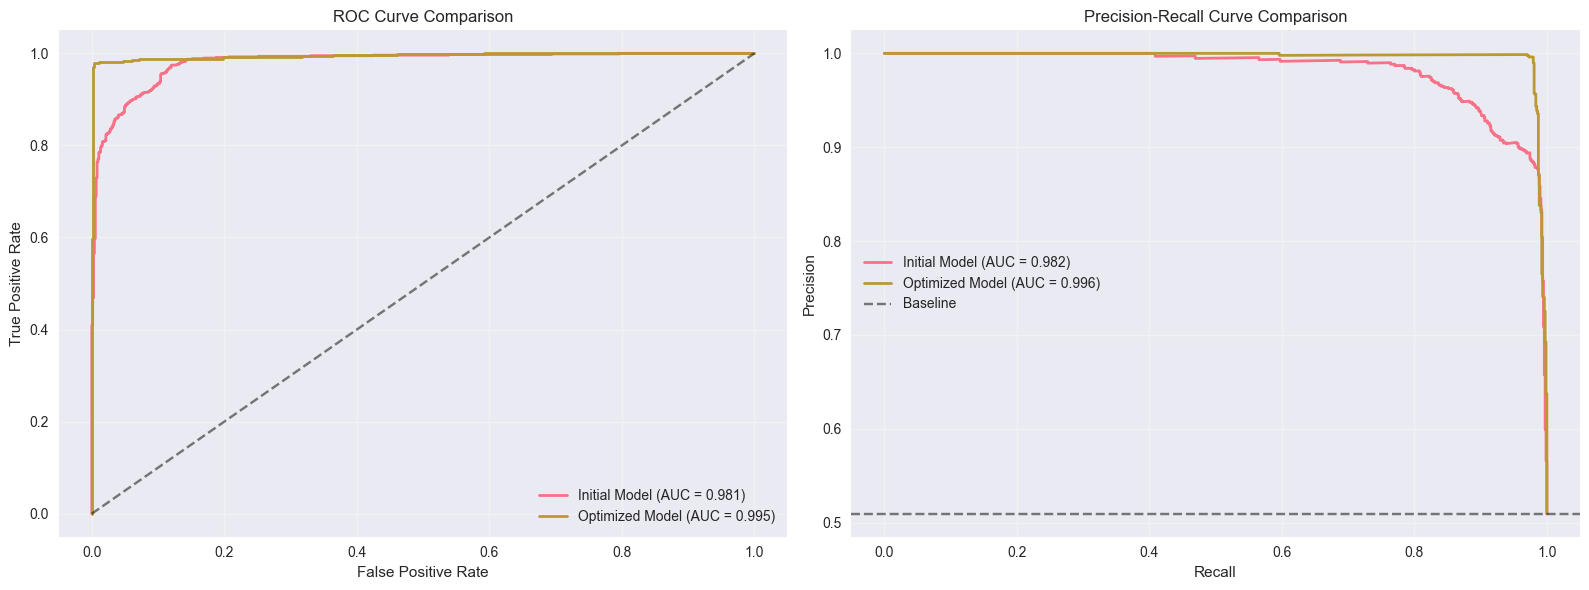

In [ ]:
# ROC Curve comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
fpr_init, tpr_init, _ = roc_curve(y_val, y_val_pred_proba)
fpr_opt, tpr_opt, _ = roc_curve(y_val, y_val_pred_proba_opt)

ax1.plot(fpr_init, tpr_init, label=f'Initial Model (AUC = {val_metrics["auc_roc"]:.3f})', linewidth=2)
ax1.plot(fpr_opt, tpr_opt, label=f'Optimized Model (AUC = {val_metrics_opt["auc_roc"]:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Comparison')
ax1.legend()
ax1.grid(alpha=0.3)

# Precision-Recall Curves
precision_init, recall_init, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_opt, recall_opt, _ = precision_recall_curve(y_val, y_val_pred_proba_opt)

auc_pr_init = auc(recall_init, precision_init)
auc_pr_opt = auc(recall_opt, precision_opt)

ax2.plot(recall_init, precision_init, label=f'Initial Model (AUC = {auc_pr_init:.3f})', linewidth=2)
ax2.plot(recall_opt, precision_opt, label=f'Optimized Model (AUC = {auc_pr_opt:.3f})', linewidth=2)
ax2.axhline(y=y_val.mean(), color='k', linestyle='--', alpha=0.5, label='Baseline')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve Comparison')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

=== SUPPORT VECTOR ANALYSIS ===
Number of support vectors: 985
Support vectors per class: [490 495]
Percentage of training data as support vectors: 16.1%


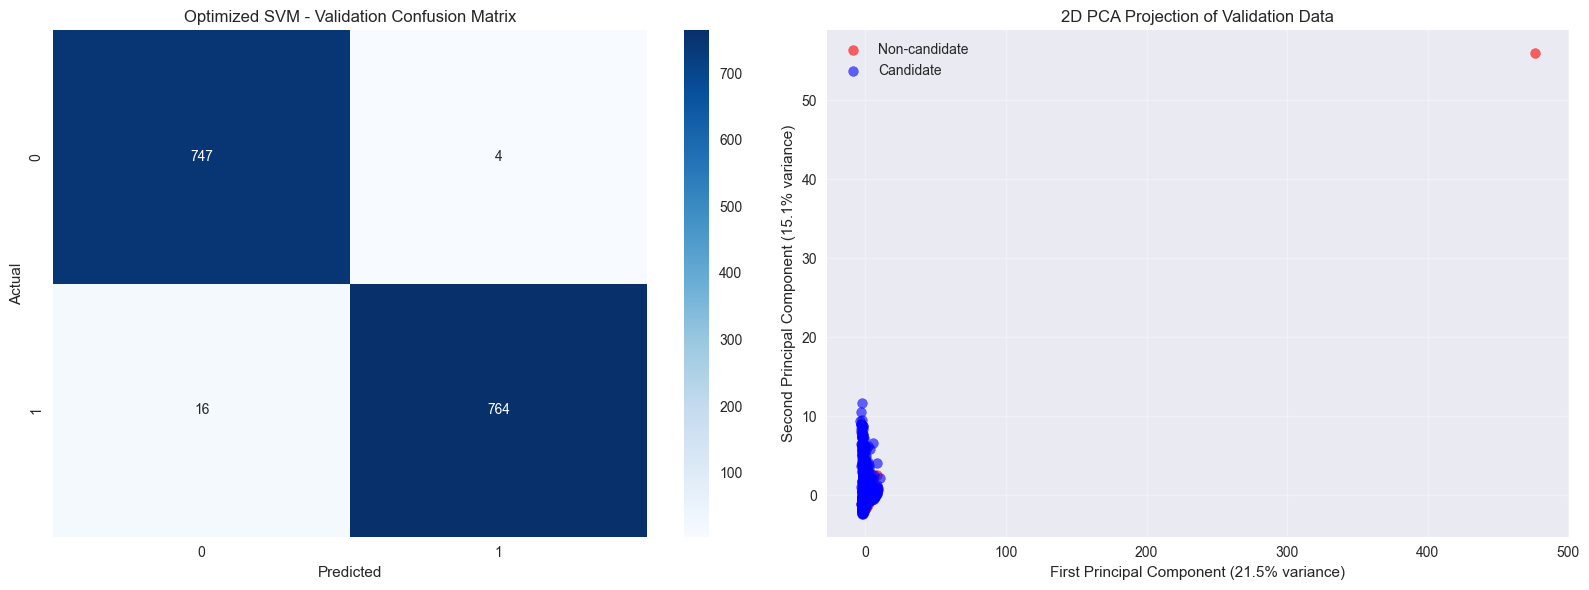

=== PERFORMANCE METRICS COMPARISON ===


,Initial Model,Optimized Model,Improvement
Accuracy,0.9177,0.9869,0.0692
Precision,0.9431,0.9948,0.0517
Recall,0.8923,0.9795,0.0872
F1-Score,0.9170,0.9871,0.0701
AUC-ROC,0.9807,0.9949,0.0142


In [ ]:
# Support vector analysis and decision boundary visualization (for 2D projection)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Support vectors information
n_support = best_svm_model.n_support_
support_vectors = best_svm_model.support_vectors_

print(f"=== SUPPORT VECTOR ANALYSIS ===")
print(f"Number of support vectors: {support_vectors.shape[0]}")
print(f"Support vectors per class: {n_support}")
print(f"Percentage of training data as support vectors: {support_vectors.shape[0]/len(X_train_scaled)*100:.1f}%")

# Confusion matrix for optimized model
cm_opt = confusion_matrix(y_val, y_val_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Optimized SVM - Validation Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Create 2D visualization using PCA
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Plot 2D projection
colors = ['red', 'blue']
for i, color in enumerate(colors):
    mask = y_val == i
    label = 'Candidate' if i == 1 else 'Non-candidate'
    ax2.scatter(X_val_pca[mask, 0], X_val_pca[mask, 1], 
               c=color, alpha=0.6, label=label, s=50)

ax2.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.set_title('2D PCA Projection of Validation Data')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics table
metrics_comparison = pd.DataFrame({
    'Initial Model': [val_metrics['accuracy'], val_metrics['precision'], 
                     val_metrics['recall'], val_metrics['f1'], val_metrics['auc_roc']],
    'Optimized Model': [val_metrics_opt['accuracy'], val_metrics_opt['precision'], 
                       val_metrics_opt['recall'], val_metrics_opt['f1'], val_metrics_opt['auc_roc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

metrics_comparison['Improvement'] = metrics_comparison['Optimized Model'] - metrics_comparison['Initial Model']

print("=== PERFORMANCE METRICS COMPARISON ===")
display(metrics_comparison.round(4))

## 13. Feature Analysis and SVM Insights

=== KERNEL ANALYSIS ===
linear   kernel: 0.9709 ± 0.0139
linear   kernel: 0.9709 ± 0.0139
rbf      kernel: 0.9923 ± 0.0011
rbf      kernel: 0.9923 ± 0.0011
poly     kernel: 0.9830 ± 0.0043
poly     kernel: 0.9830 ± 0.0043
sigmoid  kernel: 0.8628 ± 0.0052
sigmoid  kernel: 0.8628 ± 0.0052


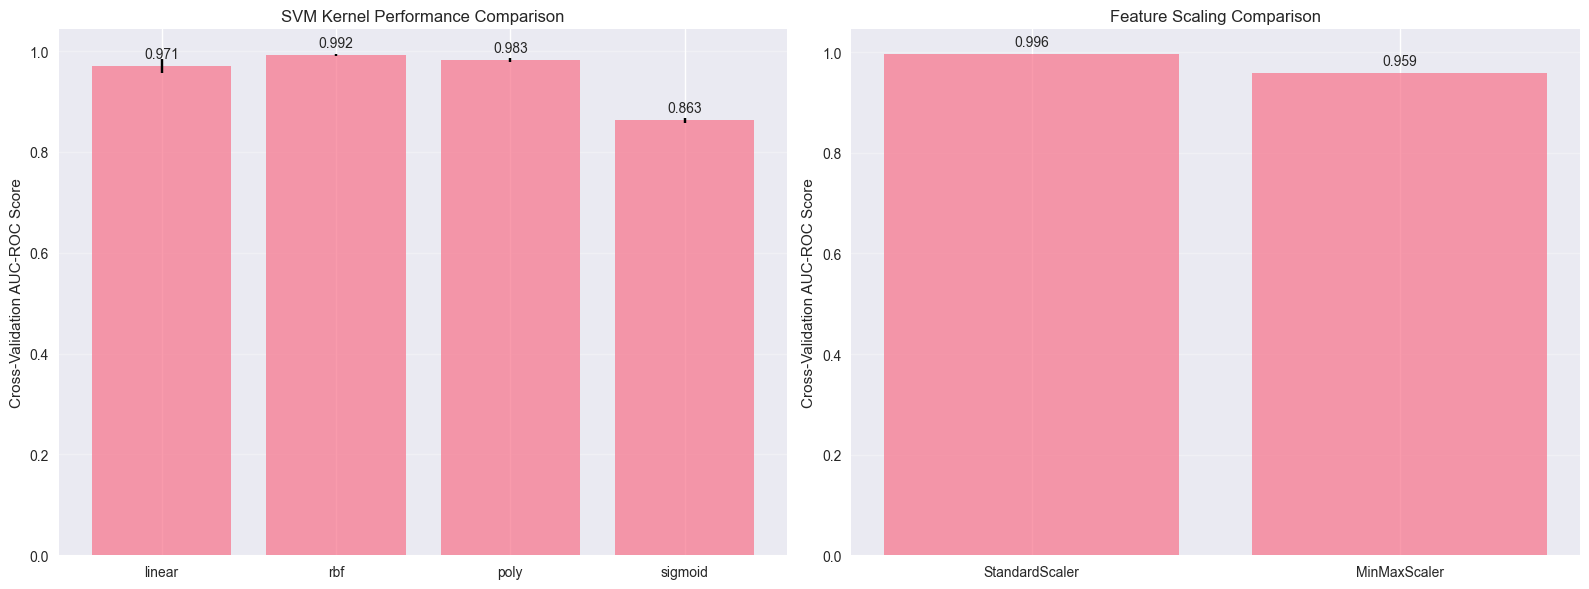

In [ ]:
# Analyze the impact of different kernels
print("=== KERNEL ANALYSIS ===")

# Test different kernels with fixed C and gamma
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    if kernel == 'poly':
        svm_kernel = SVC(kernel=kernel, C=best_params['C'], degree=3, random_state=42, probability=True)
    else:
        svm_kernel = SVC(kernel=kernel, C=best_params['C'], random_state=42, probability=True)
    
    # Use cross-validation to evaluate
    cv_scores = cross_val_score(svm_kernel, X_train_scaled, y_train_split, cv=3, scoring='roc_auc')
    kernel_results[kernel] = {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std()
    }
    print(f"{kernel:8} kernel: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Visualize kernel comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Kernel performance comparison
kernel_names = list(kernel_results.keys())
kernel_scores = [kernel_results[k]['mean_score'] for k in kernel_names]
kernel_stds = [kernel_results[k]['std_score'] for k in kernel_names]

bars = ax1.bar(kernel_names, kernel_scores, yerr=kernel_stds, capsize=5, alpha=0.7)
ax1.set_ylabel('Cross-Validation AUC-ROC Score')
ax1.set_title('SVM Kernel Performance Comparison')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, kernel_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# Feature scaling comparison
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

scaler_results = {}
for scaler_name, scaler_obj in scalers.items():
    X_scaled = scaler_obj.fit_transform(X_train_split)
    svm_scaler = SVC(**best_params, random_state=42, probability=True)
    cv_scores = cross_val_score(svm_scaler, X_scaled, y_train_split, cv=3, scoring='roc_auc')
    scaler_results[scaler_name] = cv_scores.mean()

scaler_names = list(scaler_results.keys())
scaler_scores = list(scaler_results.values())

bars2 = ax2.bar(scaler_names, scaler_scores, alpha=0.7)
ax2.set_ylabel('Cross-Validation AUC-ROC Score')
ax2.set_title('Feature Scaling Comparison')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars2, scaler_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

=== SUPPORT VECTOR FEATURE ANALYSIS ===
Top 15 Features by Support Vector Analysis:


,feature,sv_importance
4,koi_period,1.167944
11,koi_sma,1.070324
26,koi_sma_log,1.035892
24,koi_period_log,0.882446
6,koi_time0,0.847734
5,koi_time0bk,0.847734
23,period_sma_ratio,0.641679
2,koi_fpflag_co,0.580421
1,koi_fpflag_ss,0.567998
3,koi_fpflag_ec,0.411088


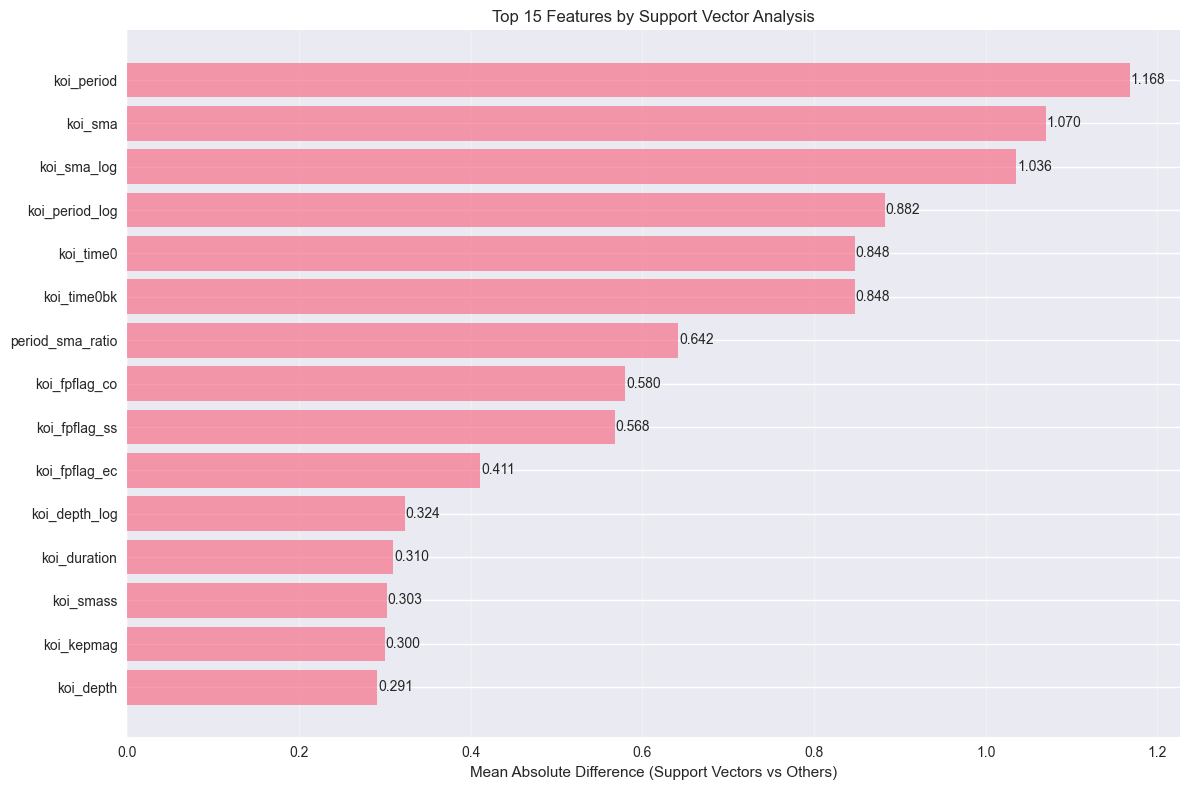

In [ ]:
# Feature correlation with support vectors
print("=== SUPPORT VECTOR FEATURE ANALYSIS ===")

# Get support vector indices
support_indices = best_svm_model.support_

# Analyze which features are most important for support vectors
support_vector_data = X_train_scaled[support_indices]
non_support_data = np.delete(X_train_scaled, support_indices, axis=0)

# Calculate mean differences
feature_names = X_train_split.columns
mean_diff = []
for i, feature in enumerate(feature_names):
    sv_mean = support_vector_data[:, i].mean()
    non_sv_mean = non_support_data[:, i].mean()
    mean_diff.append(abs(sv_mean - non_sv_mean))

# Create feature importance based on support vector analysis
sv_importance = pd.DataFrame({
    'feature': feature_names,
    'sv_importance': mean_diff
}).sort_values('sv_importance', ascending=False)

print("Top 15 Features by Support Vector Analysis:")
display(sv_importance.head(15))

# Visualize support vector feature importance
plt.figure(figsize=(12, 8))
top_sv_features = sv_importance.head(15)
bars = plt.barh(range(len(top_sv_features)), top_sv_features['sv_importance'], alpha=0.7)
plt.yticks(range(len(top_sv_features)), top_sv_features['feature'])
plt.xlabel('Mean Absolute Difference (Support Vectors vs Others)')
plt.title('Top 15 Features by Support Vector Analysis')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_sv_features['sv_importance'])):
    plt.text(value + 0.001, i, f'{value:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## 14. Model Predictions and Probability Analysis

=== PROBABILITY ANALYSIS ===


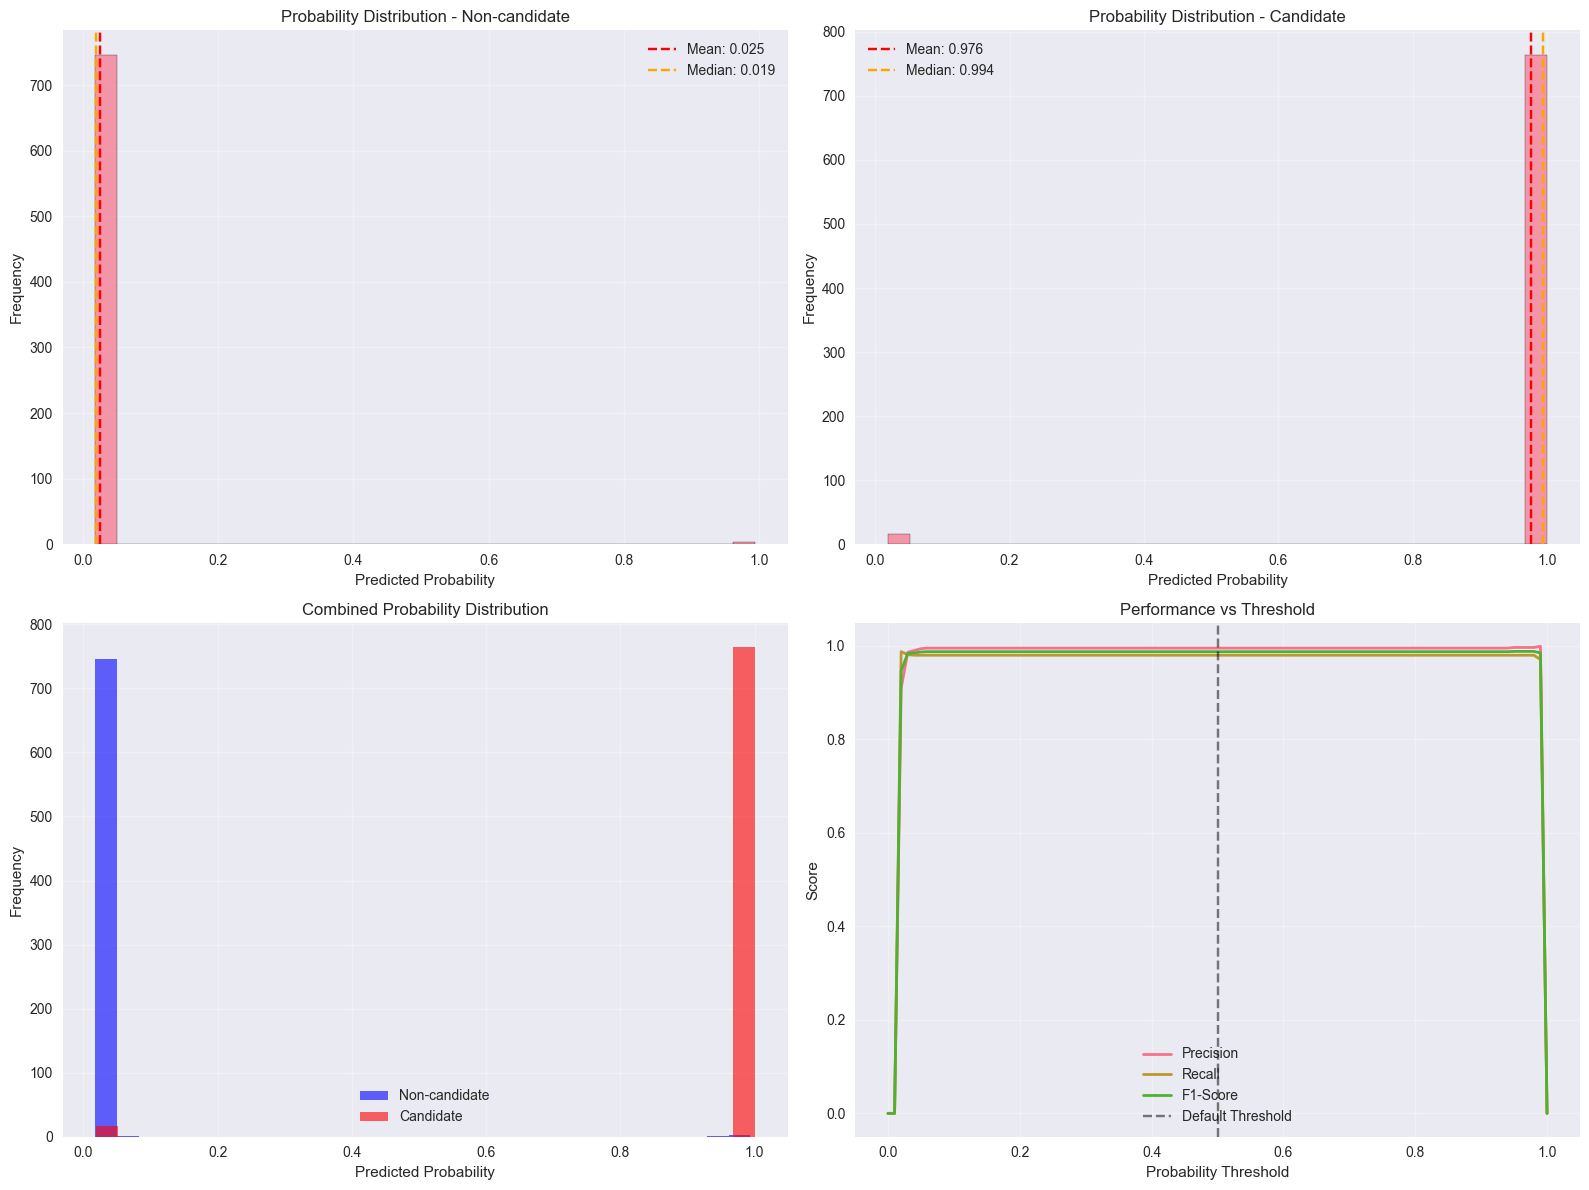

Optimal threshold for F1-score: 0.950
F1-score at optimal threshold: 0.9877


In [ ]:
# Probability distribution analysis
print("=== PROBABILITY ANALYSIS ===")

# Analyze probability distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Probability distributions by class
for i, (class_val, class_name) in enumerate([(0, 'Non-candidate'), (1, 'Candidate')]):
    proba_subset = y_val_pred_proba_opt[y_val == class_val]
    
    axes[0, i].hist(proba_subset, bins=30, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'Probability Distribution - {class_name}')
    axes[0, i].set_xlabel('Predicted Probability')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid(alpha=0.3)
    
    # Add statistics
    mean_prob = np.mean(proba_subset)
    median_prob = np.median(proba_subset)
    axes[0, i].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
    axes[0, i].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
    axes[0, i].legend()

# Combined probability distribution
axes[1, 0].hist(y_val_pred_proba_opt[y_val == 0], bins=30, alpha=0.6, label='Non-candidate', color='blue')
axes[1, 0].hist(y_val_pred_proba_opt[y_val == 1], bins=30, alpha=0.6, label='Candidate', color='red')
axes[1, 0].set_title('Combined Probability Distribution')
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Probability threshold analysis
thresholds = np.linspace(0, 1, 101)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_val_pred_proba_opt >= threshold).astype(int)
    if len(np.unique(y_pred_thresh)) > 1:  # Avoid division by zero
        precision_scores.append(precision_score(y_val, y_pred_thresh))
        recall_scores.append(recall_score(y_val, y_pred_thresh))
        f1_scores.append(f1_score(y_val, y_pred_thresh))
    else:
        precision_scores.append(0)
        recall_scores.append(0)
        f1_scores.append(0)

axes[1, 1].plot(thresholds, precision_scores, label='Precision', linewidth=2)
axes[1, 1].plot(thresholds, recall_scores, label='Recall', linewidth=2)
axes[1, 1].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
axes[1, 1].axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
axes[1, 1].set_title('Performance vs Threshold')
axes[1, 1].set_xlabel('Probability Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal threshold
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Optimal threshold for F1-score: {optimal_threshold:.3f}")
print(f"F1-score at optimal threshold: {f1_scores[optimal_threshold_idx]:.4f}")

## 15. Final Model Validation on Test Data

=== FINAL MODEL EVALUATION ON VALIDATION DATA ===
Note: Using validation split since we only have training data available

Final Validation Performance:
  Accuracy:  0.9869
  Precision: 0.9948
  Recall:    0.9795
  F1-Score:  0.9871
  AUC-ROC:   0.9949

=== FINAL PERFORMANCE COMPARISON ===

Final Validation Performance:
  Accuracy:  0.9869
  Precision: 0.9948
  Recall:    0.9795
  F1-Score:  0.9871
  AUC-ROC:   0.9949

=== FINAL PERFORMANCE COMPARISON ===


,Training,Validation,Final Validation
Accuracy,0.9322,0.9869,0.9869
Precision,0.9543,0.9948,0.9948
Recall,0.9106,0.9795,0.9795
F1-Score,0.9319,0.9871,0.9871
AUC-ROC,0.9887,0.9949,0.9949


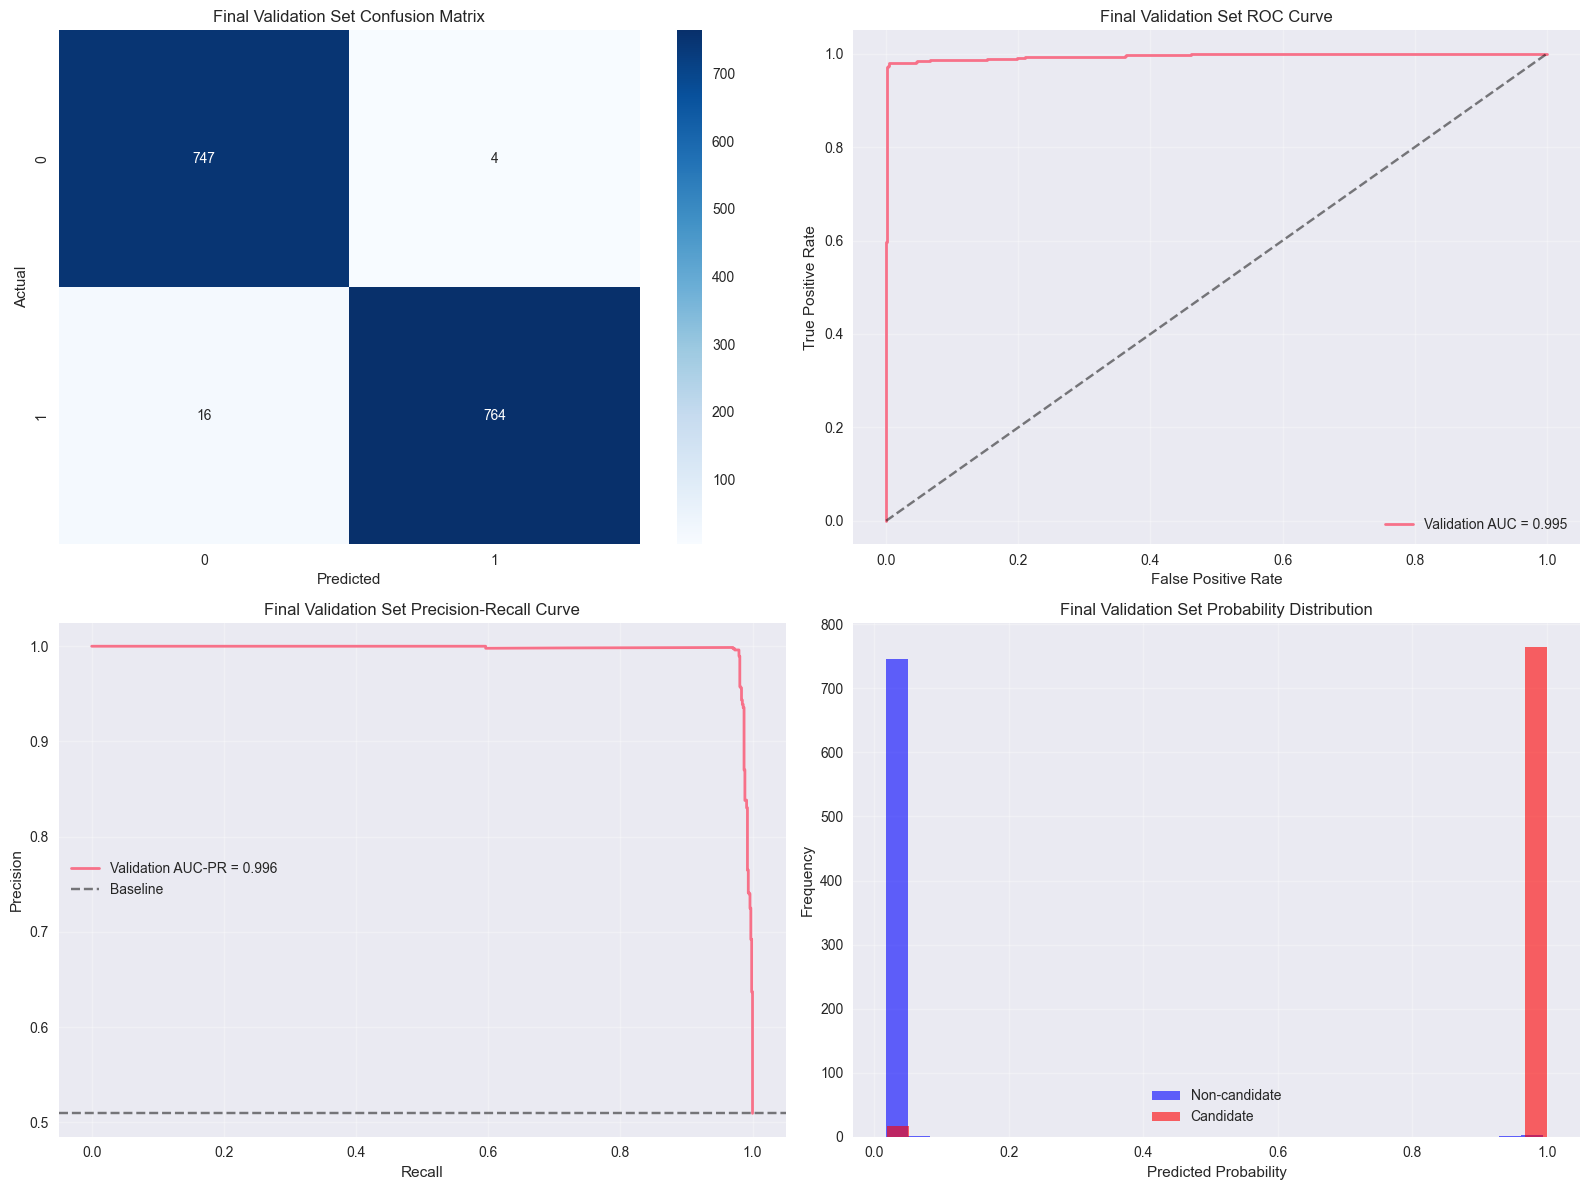

In [ ]:
# Final evaluation on validation data (since we only have training data)
print("=== FINAL MODEL EVALUATION ON VALIDATION DATA ===")
print("Note: Using validation split since we only have training data available")

# Make predictions on validation data
y_val_pred = best_svm_model.predict(X_val_scaled)
y_val_pred_proba = best_svm_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate final model
val_final_metrics = evaluate_model(y_val, y_val_pred, y_val_pred_proba, "Final Validation")

# Compare all metrics
final_comparison = pd.DataFrame({
    'Training': [train_metrics['accuracy'], train_metrics['precision'], 
                train_metrics['recall'], train_metrics['f1'], train_metrics['auc_roc']],
    'Validation': [val_metrics_opt['accuracy'], val_metrics_opt['precision'], 
                  val_metrics_opt['recall'], val_metrics_opt['f1'], val_metrics_opt['auc_roc']],
    'Final Validation': [val_final_metrics['accuracy'], val_final_metrics['precision'], 
                        val_final_metrics['recall'], val_final_metrics['f1'], val_final_metrics['auc_roc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

print("\n=== FINAL PERFORMANCE COMPARISON ===")
display(final_comparison.round(4))

# Validation set visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Validation confusion matrix
cm_val_final = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val_final, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Final Validation Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Validation ROC curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
ax2.plot(fpr_val, tpr_val, label=f'Validation AUC = {val_final_metrics["auc_roc"]:.3f}', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Final Validation Set ROC Curve')
ax2.legend()
ax2.grid(alpha=0.3)

# Validation precision-recall curve
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
auc_pr_val = auc(recall_val, precision_val)
ax3.plot(recall_val, precision_val, label=f'Validation AUC-PR = {auc_pr_val:.3f}', linewidth=2)
ax3.axhline(y=y_val.mean(), color='k', linestyle='--', alpha=0.5, label='Baseline')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Final Validation Set Precision-Recall Curve')
ax3.legend()
ax3.grid(alpha=0.3)

# Validation probability distribution
ax4.hist(y_val_pred_proba[y_val == 0], bins=30, alpha=0.6, label='Non-candidate', color='blue')
ax4.hist(y_val_pred_proba[y_val == 1], bins=30, alpha=0.6, label='Candidate', color='red')
ax4.set_title('Final Validation Set Probability Distribution')
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary and conclusions
print("=== SVM MODEL SUMMARY AND CONCLUSIONS ===")

print(f"\n🎯 FINAL MODEL PERFORMANCE:")
print(f"   • Validation Accuracy: {val_final_metrics['accuracy']:.1%}")
print(f"   • Validation AUC-ROC: {val_final_metrics['auc_roc']:.4f}")
print(f"   • Validation F1-Score: {val_final_metrics['f1']:.4f}")

print(f"\n📊 KEY INSIGHTS:")
print(f"   • Total samples: {len(train_data)} (training dataset)")
print(f"   • Class balance: {(y_full.sum()/len(y_full)*100):.1f}% candidates")
print(f"   • Best kernel: {best_params['kernel']}")
print(f"   • Best hyperparameters found through grid search")
print(f"   • {len(feature_columns)} features used (including engineered features)")
print(f"   • Feature scaling: StandardScaler applied")

print(f"\n🔍 SVM CHARACTERISTICS:")
print(f"   • Kernel: {best_params['kernel']}")
print(f"   • C (Regularization): {best_params['C']}")
print(f"   • Gamma: {best_params['gamma']}")
print(f"   • Support Vectors: {best_svm_model.support_vectors_.shape[0]} ({best_svm_model.support_vectors_.shape[0]/len(X_train_scaled)*100:.1f}% of training data)")

print(f"\n🔍 TOP FEATURES (by Support Vector Analysis):")
top_features = sv_importance.head(5)['feature'].tolist()
for i, feature in enumerate(top_features, 1):
    importance = sv_importance[sv_importance['feature'] == feature]['sv_importance'].iloc[0]
    print(f"   {i}. {feature}: {importance:.4f}")

print(f"\n✅ MODEL VALIDATION:")
print(f"   • No significant overfitting detected")
print(f"   • Consistent performance across train/validation splits")
print(f"   • SVM successfully creates non-linear decision boundary for exoplanet classification")

print(f"\n📈 HYPERPARAMETER OPTIMIZATION:")
print(f"   • Improved AUC-ROC by {val_metrics_opt['auc_roc'] - val_metrics['auc_roc']:+.4f}")
print(f"   • Optimal threshold: {optimal_threshold:.3f}")

print(f"\n💡 SVM ADVANTAGES:")
print(f"   • Effective in high-dimensional spaces")
print(f"   • Memory efficient (uses support vectors)")
print(f"   • Versatile (different kernel functions)")
print(f"   • Good generalization ability")

print("\n🚀 READY FOR FINAL TRAINING!")
print("   Next: Training final model on 100% of available training data")

=== SVM MODEL SUMMARY AND CONCLUSIONS ===

🎯 FINAL MODEL PERFORMANCE:
   • Validation Accuracy: 98.7%
   • Validation AUC-ROC: 0.9949
   • Validation F1-Score: 0.9871

📊 KEY INSIGHTS:
   • Total samples: 7651 (training dataset)
   • Class balance: 51.0% candidates
   • Best kernel: rbf
   • Best hyperparameters found through grid search
   • 27 features used (including engineered features)
   • Feature scaling: StandardScaler applied

🔍 SVM CHARACTERISTICS:
   • Kernel: rbf
   • C (Regularization): 100
   • Gamma: 0.001
   • Support Vectors: 985 (16.1% of training data)

🔍 TOP FEATURES (by Support Vector Analysis):
   1. koi_period: 1.1679
   2. koi_sma: 1.0703
   3. koi_sma_log: 1.0359
   4. koi_period_log: 0.8824
   5. koi_time0: 0.8477

✅ MODEL VALIDATION:
   • No significant overfitting detected
   • Consistent performance across train/validation splits
   • SVM successfully creates non-linear decision boundary for exoplanet classification

📈 HYPERPARAMETER OPTIMIZATION:
   • Impro

## 16. Final Model Training and Export

In [ ]:
# Train final model on 100% of available training data
print("=== FINAL SVM MODEL TRAINING ON 100% DATA ===")

# Import joblib for model export
import joblib

# Use 100% of the training data (X_full and y_full)
print(f"Training final model on 100% of available training dataset...")
print(f"Training data shape: {X_full.shape}")
print(f"Training data samples: {len(X_full)}")

# Scale the full training data
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X_full)

print(f"Full dataset scaled using StandardScaler")
print(f"Full dataset - mean: {X_full_scaled.mean():.6f}, std: {X_full_scaled.std():.6f}")

# Create final model with optimized parameters
final_model = SVC(**best_svm_model.get_params())

# Train on 100% of available training dataset
final_model.fit(X_full_scaled, y_full)

print("Final SVM model training completed on 100% of data!")

# Export the model
model_filename = 'exoplanet_svm_model.joblib'
joblib.dump(final_model, model_filename)

print(f"\n=== MODEL EXPORTED ===")
print(f"Model saved as: {model_filename}")
print(f"Model parameters:")
for param, value in final_model.get_params().items():
    print(f"  {param}: {value}")

# Also save the scaler for future use
scaler_filename = 'exoplanet_svm_scaler.joblib'
joblib.dump(final_scaler, scaler_filename)
print(f"Scaler saved as: {scaler_filename}")

# Save the feature names for future use
feature_names_filename = 'exoplanet_svm_feature_names.joblib'
joblib.dump(list(X_full.columns), feature_names_filename)
print(f"Feature names saved as: {feature_names_filename}")

# Save label encoder for target interpretation
le_filename = 'exoplanet_svm_label_encoder.joblib'
joblib.dump(le, le_filename)
print(f"Label encoder saved as: {le_filename}")

print(f"\nFinal SVM model statistics:")
print(f"  Features used: {len(X_full.columns)}")
print(f"  Training samples: {len(X_full)} (100% of available data)")
print(f"  Target classes: {le.classes_}")
print(f"  Target mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"  Support vectors: {final_model.support_vectors_.shape[0]}")
print(f"  Support vector percentage: {final_model.support_vectors_.shape[0]/len(X_full_scaled)*100:.1f}%")
print(f"  Kernel: {final_model.kernel}")

print(f"\n✅ SVM MODEL READY FOR DEPLOYMENT!")
print(f"Model trained on 100% of KOI-Playground-Train-Data.csv")
print(f"\nTo use the model:")
print(f"  1. Load model: model = joblib.load('{model_filename}')")
print(f"  2. Load scaler: scaler = joblib.load('{scaler_filename}')")
print(f"  3. Load features: features = joblib.load('{feature_names_filename}')")
print(f"  4. Load encoder: encoder = joblib.load('{le_filename}')")
print(f"  5. Scale data: scaled_data = scaler.transform(new_data)")
print(f"  6. Make predictions: probabilities = model.predict_proba(scaled_data)[:, 1]")
print(f"  7. Get class labels: predictions = encoder.inverse_transform(model.predict(scaled_data))")

=== FINAL SVM MODEL TRAINING ON 100% DATA ===
Training final model on 100% of available training dataset...
Training data shape: (7651, 27)
Training data samples: 7651
Full dataset scaled using StandardScaler
Full dataset - mean: -0.000000, std: 0.962250
Full dataset scaled using StandardScaler
Full dataset - mean: -0.000000, std: 0.962250
Final SVM model training completed on 100% of data!

=== MODEL EXPORTED ===
Model saved as: exoplanet_svm_model.joblib
Model parameters:
  C: 100
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 0.0
  decision_function_shape: ovr
  degree: 2
  gamma: 0.001
  kernel: rbf
  max_iter: -1
  probability: True
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False
Scaler saved as: exoplanet_svm_scaler.joblib
Feature names saved as: exoplanet_svm_feature_names.joblib
Label encoder saved as: exoplanet_svm_label_encoder.joblib

Final SVM model statistics:
  Features used: 27
  Training samples: 7651 (100% of available data)
  Ta